In [2]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import numpy as np
import tensorflow as tf
import os, sys, time
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import utils, optimization, metrics, plot, data
import pickle

# Parameters

In [4]:
ns = 64
scalings = [2, 2, 2]
nsamples = 2000
k = 10

# Data handling

Load the data

In [5]:
images, raw_images = data.load_samples(nsamples = nsamples, permute=True, k=k)
images = data.make_smaller_samples(images, ns)
raw_images = data.make_smaller_samples(raw_images, ns)

Select 2000 samples out of 15000.


In [6]:
down_sampled_images = data.down_sample_images(images, scalings)

Let us plot 16 images

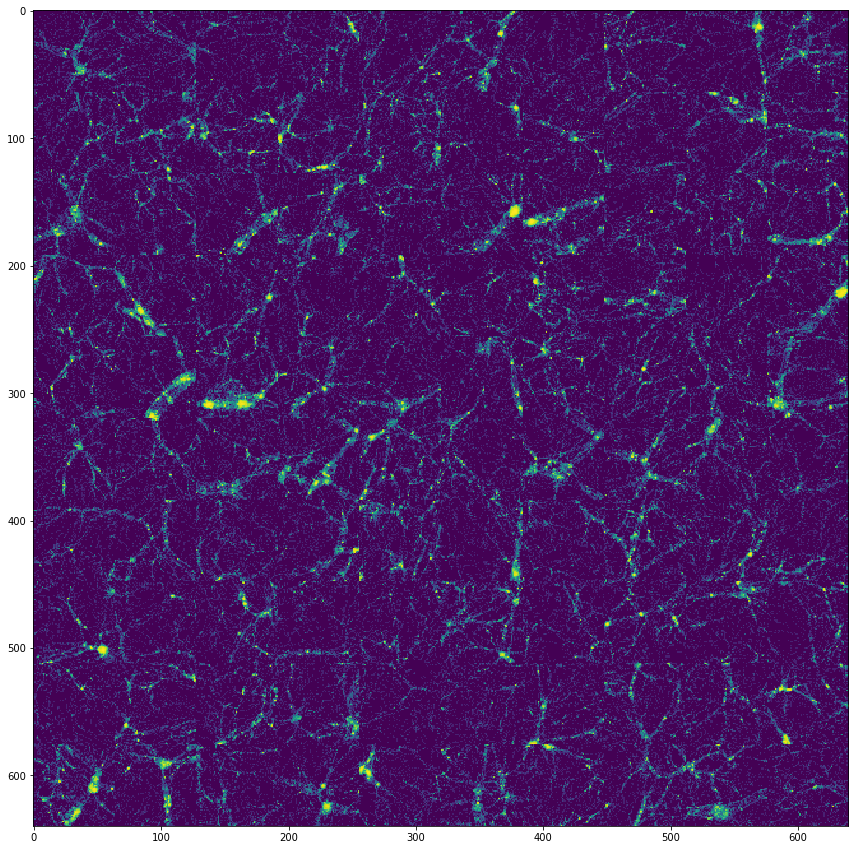

In [7]:
plt.figure(figsize=(15,15))
utils.draw_images(images,nx=10,ny=10,px=ns,py=ns)

# A) Different GAN training

In [47]:
def current_time_str():
    import time, datetime
    d = datetime.datetime.fromtimestamp(time.time())
    return str(d.year)+ '_' + str(d.month)+ '_' + str(d.day)+ '_' + str(d.hour)+ '_' + str(d.minute)

time_str = current_time_str() 
global_path = '../../saved_result/'


In [69]:
params0 = dict()
params0['prior_distribution'] = 'gaussian'
params0['clip_max_real'] = False
params0['log_clip'] = 0.1
params0['sigma_smooth'] = 1
params0['k'] = k
params0['sum_every'] = 200
params0['viz_every'] = 200
params0['save_every'] = 2000

params_optimization = dict()
params_optimization['gamma_gp'] = 10
params_optimization['weight_l2'] = 0.1
params_optimization['batch_size'] = 16
params_optimization['gen_optimizer'] = 'adam' # rmsprop / adam / sgd
params_optimization['disc_optimizer'] = 'adam' # rmsprop / adam /sgd
params_optimization['disc_learning_rate'] = 3e-5
params_optimization['gen_learning_rate'] = 3e-5
params_optimization['beta1'] = 0.0
params_optimization['beta2'] = 0.9
params_optimization['epsilon'] = 1e-8
params_optimization['epoch'] = 10


In [25]:
level = 3

new_ns = ns//np.prod(scalings)
latent_dim = new_ns**2
bn = False
params_discriminator = dict()
params_discriminator['stride'] = [2, 2 , 1]
params_discriminator['nfilter'] = [16, 32, 64]
params_discriminator['shape'] = [[5, 5], [3, 3], [3, 3]]
params_discriminator['batch_norm'] = [bn, bn, bn]
params_discriminator['full'] = [128]
params_discriminator['summary'] = True
params_discriminator['minibatch_reg'] = False

params_generator = dict()
params_generator['stride'] = [2, 2, 1]
params_generator['latent_dim'] = latent_dim
params_generator['nfilter'] = [128 ,64, 1]
params_generator['shape'] = [[3, 3], [3, 3], [5, 5]]
params_generator['batch_norm'] = [bn, bn]
params_generator['full'] = [2*2*128]
params_generator['summary'] = True
params_generator['non_lin'] = None


params = params0.copy()
params['generator'] = params_generator
params['discriminator'] = params_discriminator
params['optimization'] = params_optimization

params['normalize'] = True
params['image_size'] = [new_ns, new_ns]
params['name'] = 'LAPWGAN{}_level{}_'.format(ns, level)
params['summary_dir'] = global_path + params['name'] + '_' + time_str +'summary/'
params['save_dir'] = global_path + params['name'] + '_' + time_str + 'checkpoints/'


In [30]:
from model import WGanModel
from gan import GAN

obj = GAN(params, WGanModel)
obj.train(down_sampled_images[level])

KeyError: 'full'

In [70]:
level = 2

up_scaling = scalings[level]
new_ns = ns//np.prod(scalings[:level+1])
latent_dim = new_ns**2
bn = False
params_discriminator = dict()
params_discriminator['stride'] = [2, 2, 2 , 1]
params_discriminator['nfilter'] = [16, 128, 128, 64]
params_discriminator['shape'] = [[5, 5],[5, 5], [3, 3], [3, 3]]
params_discriminator['batch_norm'] = [bn, bn, bn, bn]
params_discriminator['full'] = [128]
params_discriminator['summary'] = True
params_discriminator['minibatch_reg'] = False

params_generator = dict()
params_generator['stride'] = [1, 1, 2, 1]
params_generator['latent_dim'] = latent_dim
params_generator['nfilter'] = [64, 128 ,64, 1]
params_generator['shape'] = [[5, 5], [5, 5], [5, 5], [5, 5]]
params_generator['batch_norm'] = [bn, bn, bn]
params_generator['summary'] = True
params_generator['non_lin'] = 'tanh'
params_generator['upsampling'] = up_scaling

params = params0.copy()
params['generator'] = params_generator
params['discriminator'] = params_discriminator
params['optimization'] = params_optimization

params['normalize'] = False
params['image_size'] = [new_ns*up_scaling, new_ns*up_scaling]
params['name'] = 'LAPWGAN{}_level{}_'.format(ns, level)
params['summary_dir'] = global_path + params['name'] + '_' + time_str +'summary/'
params['save_dir'] = global_path + params['name'] + '_' + time_str + 'checkpoints/'



In [71]:
from model import LapGanModel
from gan import GAN

obj = GAN(params, LapGanModel)
obj.train(X=down_sampled_images[level])

Generator 
------------------------------------------------------------
     The input X is of size (?, 8, 8, 1)
     The input z is of size (?, 64)
     Reshape z to (?, 8, 8, 1)
     Concat x and z to (?, 8, 8, 2)
     0 Deconv layer with 64 channels
         Batch norm
         Size of the variables: (?, 8, 8, 64)
     1 Deconv layer with 128 channels
         Batch norm
         Size of the variables: (?, 8, 8, 128)
     2 Deconv layer with 64 channels
         Batch norm
         Size of the variables: (?, 16, 16, 64)
     3 Deconv layer with 1 channels
         Size of the variables: (?, 16, 16, 1)
    Non lienarity: tanh
     The output is of size (?, 16, 16, 1)
------------------------------------------------------------

Discriminator 
------------------------------------------------------------
     The input is of size (?, 16, 16, 3)
     0 Conv layer with 16 channels
         Size of the variables: (?, 8, 8, 16)
     1 Conv layer with 128 channels
         Size of the varia

 1800 current PSD L2 71769731.99064007, logL2 184.0279089023898
Epoch: [ 0] [1899/2000] Counter:1900	( 6.0 min	75.65 examples/sec	0.212 sec/batch)	L_Disc:0.21652408	L_Gen:-1.54052019
Epoch: [ 0] [1999/2000] Counter:2000	( 6.3 min	92.13 examples/sec	0.174 sec/batch)	L_Disc:0.28789827	L_Gen:-1.51223266
Epoch: [ 1] [ 499/2000] Counter:2500	( 7.9 min	75.33 examples/sec	0.212 sec/batch)	L_Disc:0.16711503	L_Gen:-1.18084407
Epoch: [ 1] [ 599/2000] Counter:2600	( 8.2 min	96.47 examples/sec	0.166 sec/batch)	L_Disc:0.15134822	L_Gen:-1.11748910
 [*] [Fake, Real] Min [0.100, 0.274],	Median [0.100,0.604],	Mean [1.143E-01,7.111E-01],	 Max [9.400E-01,2.480E+00],	 Var [6.411E-03,1.632E-01]
 [*] [Comp, Fake, Real] PeakDistance:[1.475, 0.000, 0.070]	CrossPS:[3.703, 13.666, -3.999]	PSD_Diff:336.637
 2600 current PSD L2 227625570.19651496, logL2 262.826996534307
Epoch: [ 1] [ 699/2000] Counter:2700	( 8.5 min	75.16 examples/sec	0.213 sec/batch)	L_Disc:0.16810104	L_Gen:-1.06222868
Epoch: [ 1] [ 799/2000] Co

Epoch: [ 2] [1399/2000] Counter:5400	(17.1 min	95.01 examples/sec	0.168 sec/batch)	L_Disc:-0.25843948	L_Gen:-0.31956685
 [*] [Fake, Real] Min [0.100, 0.242],	Median [0.100,0.670],	Mean [2.103E+06,9.320E-01],	 Max [3.764E+07,6.660E+00],	 Var [4.952E+13,1.949E+00]
 [*] [Comp, Fake, Real] PeakDistance:[2.185, 0.000, 0.326]	CrossPS:[-6.829, -193.252, -5.081]	PSD_Diff:1180353.042
 5400 current PSD L2 20577648.671473514, logL2 94.17290997779914
Epoch: [ 2] [1499/2000] Counter:5500	(17.4 min	75.80 examples/sec	0.211 sec/batch)	L_Disc:-0.29061195	L_Gen:-0.35598320
Epoch: [ 2] [1599/2000] Counter:5600	(17.7 min	98.80 examples/sec	0.162 sec/batch)	L_Disc:-0.29118872	L_Gen:-0.33575457
 [*] [Fake, Real] Min [0.100, 0.281],	Median [0.100,0.676],	Mean [1.185E+00,8.969E-01],	 Max [1.086E+02,5.914E+00],	 Var [6.848E+01,1.032E+00]
 [*] [Comp, Fake, Real] PeakDistance:[1.322, 0.000, 0.049]	CrossPS:[-26.012, 157.589, -4.132]	PSD_Diff:25153354.648
 5600 current PSD L2 326622230.2044653, logL2 290.73140383

 8200 current PSD L2 183449425.6401934, logL2 245.21439511146386
Epoch: [ 4] [ 299/2000] Counter:8300	(26.4 min	72.73 examples/sec	0.220 sec/batch)	L_Disc:-0.33392036	L_Gen:-0.57902753
Epoch: [ 4] [ 399/2000] Counter:8400	(26.7 min	97.12 examples/sec	0.165 sec/batch)	L_Disc:-0.34794852	L_Gen:-0.58916199
 [*] [Fake, Real] Min [0.100, 0.292],	Median [0.100,0.626],	Mean [1.331E-01,6.912E-01],	 Max [1.466E+00,2.517E+00],	 Var [2.239E-02,1.029E-01]
 [*] [Comp, Fake, Real] PeakDistance:[1.784, 0.000, 0.074]	CrossPS:[0.878, 134.775, -0.472]	PSD_Diff:22322.737
 8400 current PSD L2 113155793.00446494, logL2 198.2273948993566
Epoch: [ 4] [ 499/2000] Counter:8500	(27.0 min	73.30 examples/sec	0.218 sec/batch)	L_Disc:-0.42172453	L_Gen:-0.52442789
Epoch: [ 4] [ 599/2000] Counter:8600	(27.3 min	95.22 examples/sec	0.168 sec/batch)	L_Disc:-0.38164863	L_Gen:-0.58127868
 [*] [Fake, Real] Min [0.100, 0.274],	Median [0.100,0.604],	Mean [1.592E-01,7.111E-01],	 Max [3.331E+00,2.480E+00],	 Var [1.001E-01,1.63

 11200 current PSD L2 686500.9013505534, logL2 110.78303642577394
Epoch: [ 5] [1299/2000] Counter:11300	(35.9 min	73.10 examples/sec	0.219 sec/batch)	L_Disc:-0.34470081	L_Gen:-2.29515433
Epoch: [ 5] [1399/2000] Counter:11400	(36.2 min	98.75 examples/sec	0.162 sec/batch)	L_Disc:-0.39216745	L_Gen:-1.91219652
 [*] [Fake, Real] Min [0.100, 0.242],	Median [0.100,0.670],	Mean [1.343E+00,9.320E-01],	 Max [7.563E+01,6.660E+00],	 Var [5.219E+01,1.949E+00]
 [*] [Comp, Fake, Real] PeakDistance:[0.835, 0.000, 0.326]	CrossPS:[-8.800, 1014.653, -5.081]	PSD_Diff:10446544.341
 11400 current PSD L2 275434484.35062796, logL2 279.01903843903796
Epoch: [ 5] [1499/2000] Counter:11500	(36.6 min	71.76 examples/sec	0.223 sec/batch)	L_Disc:-0.39259246	L_Gen:-1.80724740
Epoch: [ 5] [1599/2000] Counter:11600	(36.8 min	95.47 examples/sec	0.168 sec/batch)	L_Disc:-0.44051948	L_Gen:-1.65978718
 [*] [Fake, Real] Min [0.100, 0.281],	Median [0.100,0.676],	Mean [8.371E+00,8.969E-01],	 Max [5.414E+02,5.914E+00],	 Var [2.

 14000 current PSD L2 143900.0413609951, logL2 14.97658017996623
Epoch: [ 7] [  99/2000] Counter:14100	(44.9 min	71.08 examples/sec	0.225 sec/batch)	L_Disc:0.14865719	L_Gen:-6.27368736
Epoch: [ 7] [ 199/2000] Counter:14200	(45.1 min	97.21 examples/sec	0.165 sec/batch)	L_Disc:0.09999264	L_Gen:-6.08515358
 [*] [Fake, Real] Min [0.201, 0.288],	Median [0.940,0.781],	Mean [1.164E+00,9.665E-01],	 Max [5.269E+00,5.264E+00],	 Var [8.611E-01,5.599E-01]
 [*] [Comp, Fake, Real] PeakDistance:[0.392, 0.055, 0.124]	CrossPS:[-17.126, -26.319, -13.487]	PSD_Diff:88.965
 [*] New PSD Low achieved 137449.017978 (was 138401.589071)
 14200 current PSD L2 137449.0179779451, logL2 14.807599633454775
Epoch: [ 7] [ 299/2000] Counter:14300	(45.5 min	70.94 examples/sec	0.226 sec/batch)	L_Disc:0.03080307	L_Gen:-5.78409195
Epoch: [ 7] [ 399/2000] Counter:14400	(45.8 min	97.78 examples/sec	0.164 sec/batch)	L_Disc:-0.02691985	L_Gen:-5.58367348
 [*] [Fake, Real] Min [0.180, 0.292],	Median [0.645,0.626],	Mean [7.798E-0

Epoch: [ 8] [ 999/2000] Counter:17000	(54.0 min	97.04 examples/sec	0.165 sec/batch)	L_Disc:-0.05849808	L_Gen:-5.70657110
 [*] [Fake, Real] Min [0.333, 0.268],	Median [0.579,0.654],	Mean [7.176E-01,9.215E-01],	 Max [2.395E+00,4.490E+00],	 Var [2.042E-01,8.009E-01]
 [*] [Comp, Fake, Real] PeakDistance:[0.276, 0.240, 0.278]	CrossPS:[-7.612, -5.500, -14.472]	PSD_Diff:1595.871
 17000 current PSD L2 117887.55068794366, logL2 27.73050052126526
Epoch: [ 8] [1099/2000] Counter:17100	(54.4 min	73.18 examples/sec	0.219 sec/batch)	L_Disc:-0.05737583	L_Gen:-5.53606606
Epoch: [ 8] [1199/2000] Counter:17200	(54.6 min	96.74 examples/sec	0.165 sec/batch)	L_Disc:-0.06417499	L_Gen:-5.70085764
 [*] [Fake, Real] Min [0.356, 0.317],	Median [0.674,0.768],	Mean [8.330E-01,9.767E-01],	 Max [2.884E+00,5.289E+00],	 Var [4.958E-01,1.894E+00]
 [*] [Comp, Fake, Real] PeakDistance:[0.260, 0.271, 0.173]	CrossPS:[1.121, 1.685, 1.353]	PSD_Diff:1992.954
 17200 current PSD L2 115091.92245179346, logL2 27.24114119283504
E

 [*] New PSD Low achieved 69596.613928 (was 71771.951670)
 19800 current PSD L2 69596.61392777407, logL2 24.55582889498958
Epoch: [ 9] [1899/2000] Counter:19900	(63.3 min	66.67 examples/sec	0.240 sec/batch)	L_Disc:0.01132780	L_Gen:-5.68496847
Epoch: [ 9] [1999/2000] Counter:20000	(63.6 min	80.45 examples/sec	0.199 sec/batch)	L_Disc:-0.03730251	L_Gen:-5.42504025
 [*] [Fake, Real] Min [0.443, 0.294],	Median [0.769,0.748],	Mean [9.895E-01,8.863E-01],	 Max [4.045E+00,2.998E+00],	 Var [8.955E-01,3.052E-01]
 [*] [Comp, Fake, Real] PeakDistance:[0.140, 0.155, 0.076]	CrossPS:[-7.848, -4.528, -8.355]	PSD_Diff:494.023
 [*] New PSD Low achieved 60781.611738 (was 69596.613928)
 20000 current PSD L2 60781.61173774951, logL2 22.507260763616337


In [ ]:
level = 1

up_scaling = scalings[level]
new_ns = ns//np.prod(scalings[:level+1])
latent_dim = new_ns**2
bn = False
params_discriminator = dict()
params_discriminator['stride'] = [2, 2, 2 , 1]
params_discriminator['nfilter'] = [16, 128, 128, 64]
params_discriminator['shape'] = [[5, 5],[5, 5], [3, 3], [3, 3]]
params_discriminator['batch_norm'] = [bn, bn, bn, bn]
params_discriminator['full'] = [128]
params_discriminator['summary'] = True
params_discriminator['minibatch_reg'] = False

params_generator = dict()
params_generator['stride'] = [1, 1, 2, 1]
params_generator['latent_dim'] = latent_dim
params_generator['nfilter'] = [64, 128 ,64, 1]
params_generator['shape'] = [[5, 5], [5, 5], [5, 5], [5, 5]]
params_generator['batch_norm'] = [bn, bn, bn]
params_generator['summary'] = True
params_generator['non_lin'] = 'tanh'
params_generator['upsampling'] = up_scaling


params = params0.copy()
params['generator'] = params_generator
params['discriminator'] = params_discriminator
params['optimization'] = params_optimization

params['normalize'] = False
params['image_size'] = [new_ns*up_scaling, new_ns*up_scaling]
params['name'] = 'LAPWGAN{}_level{}_'.format(ns, level)
params['summary_dir'] = global_path + params['name'] + '_' + time_str +'summary/'
params['save_dir'] = global_path + params['name'] + '_' + time_str + 'checkpoints/'


In [ ]:
from model import LapGanModel
from gan import GAN

obj = GAN(params, LapGanModel)
obj.train(down_sampled_images[level])

In [ ]:
level = 0

up_scaling = scalings[level]
new_ns = ns//np.prod(scalings[:level+1])
latent_dim = new_ns**2
bn = False
params_discriminator = dict()
params_discriminator['stride'] = [2, 2, 2,2 , 1]
params_discriminator['nfilter'] = [16, 128, 256, 128, 64]
params_discriminator['shape'] = [[5, 5],[5, 5], [5, 5], [3, 3], [3, 3]]
params_discriminator['batch_norm'] = [bn, bn, bn, bn, bn]
params_discriminator['full'] = [128]
params_discriminator['summary'] = True
params_discriminator['minibatch_reg'] = False

params_generator = dict()
params_generator['stride'] = [1, 1, 2, 1, 1]
params_generator['latent_dim'] = latent_dim
params_generator['nfilter'] = [64, 256, 128 ,64, 1]
params_generator['shape'] = [[5, 5], [5, 5], [5, 5], [5, 5], [5, 5]]
params_generator['batch_norm'] = [bn, bn, bn, bn]
params_generator['summary'] = True
params_generator['non_lin'] = 'tanh'
params_generator['upsampling'] = up_scaling

params = params0.copy()
params['generator'] = params_generator
params['discriminator'] = params_discriminator
params['optimization'] = params_optimization

params['normalize'] = False
params['image_size'] = [new_ns*up_scaling, new_ns*up_scaling]
params['name'] = 'LAPWGAN{}_level{}_'.format(ns, level)
params['summary_dir'] = global_path + params['name'] + '_' + time_str +'summary/'
params['save_dir'] = global_path + params['name'] + '_' + time_str + 'checkpoints/'

In [ ]:
from model import LapGanModel
from gan import GAN

obj = GAN(params, LapGanModel)
obj.train(down_sampled_images[level])